# ATAC Similarity

Simple analysis which sees how close the different single cells are to MRC5/3hr/16hr/48hr samples from the heterokaryon reprogramming system. See `20200216_heterokaryon_similarity`.

Inputs:
1. scATAC counts matrix with peak list
2. scATAC metadata
3. Cluster config
4. Count of het samples reads in scATAC peaks

In [2]:
library(ggrepel)
library(reshape2)
require(stringr)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)
library(Matrix)
library(patchwork)

## Load Data

### scATAC

In [3]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [4]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5,D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5,D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5,D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5,D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5,D0_ACTCGCTACTTGTGAC


In [5]:
regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 414473      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10268_10885,chr1,10268,10885,chr1_10268_10885
chr1_41988_42505,chr1,41988,42505,chr1_41988_42505
chr1_46058_46558,chr1,46058,46558,chr1_46058_46558
chr1_48200_48959,chr1,48200,48959,chr1_48200_48959
chr1_51306_52190,chr1,51306,52190,chr1_51306_52190
chr1_58644_59144,chr1,58644,59144,chr1_58644_59144


In [6]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [7]:
pmatRowSums = Matrix::rowSums(pmat)

### Cluster Config

In [8]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#A6D854,Pre-iPSC,14
2,#F0A118,Intermediate,12
3,#E85F6D,Fibroblast-like,3
4,#006658,Neural-like,8
5,#B03743,Fibroblast,1
6,#CF175A,Fibroblast-like,4
7,#78A824,Pre-iPSC,13
8,#F4D5CD,Intermediate,11
9,#D4B81C,Intermediate,9


In [9]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### Het Counts

In [11]:
# het_cts <- read.table("./data/20200518_n76052/het.nodox.counts.overlap.no_iPSC.merged.500.tsv", header=T)
het_cts <- read.table("../../analysis/20200216_heterokaryon_similarity/data/20201020_n62402/het.nodox.counts.overlap.no_iPSC.merge.500.tsv", header=T)
rownames(het_cts)=paste(het_cts$chrom,het_cts$start,het_cts$end,sep='_')
het_cts$chrom = NULL
het_cts$start = NULL
het_cts$end = NULL
head(het_cts)
dim(het_cts)

,het.MRC5.nodox.overlap,het.CC.nodox.overlap,het.3hr.nodox.overlap,het.16hr.nodox.overlap,het.48hr.nodox.overlap
,<int>,<int>,<int>,<int>,<int>
chr1_10268_10885,0,0,0,0,2
chr1_41988_42505,0,0,0,0,0
chr1_46058_46558,2,0,0,0,0
chr1_48200_48959,0,0,0,0,0
chr1_51306_52190,2,0,2,0,2
chr1_58644_59144,0,0,0,0,0


[1] 414632      5

In [12]:
dim(regions)
sum(rownames(regions) %in% rownames(het_cts))

[1] 414473      4

[1] 414473

In [13]:
# rearrange to same order as regions
het_cts = het_cts[rownames(regions), ]

## Process

In [14]:
sum(rowSums(het_cts<40)==0)

[1] 62987

In [15]:
het_norm_cts = t(t(het_cts)/estimateSizeFactorsForMatrix(het_cts[rowSums(het_cts<40)==0,]))
head(het_norm_cts)

,het.MRC5.nodox.overlap,het.CC.nodox.overlap,het.3hr.nodox.overlap,het.16hr.nodox.overlap,het.48hr.nodox.overlap
chr1_10268_10885,0.0000000,0,0.000000,0,2.324168
chr1_41988_42505,0.0000000,0,0.000000,0,0.000000
chr1_46058_46558,0.8078399,0,0.000000,0,0.000000
chr1_48200_48959,0.0000000,0,0.000000,0,0.000000
chr1_51306_52190,0.8078399,0,2.271407,0,2.324168
chr1_58644_59144,0.0000000,0,0.000000,0,0.000000


In [16]:
regions_gr = GRanges(sub("_", "-", sub("_", ":",rownames(het_norm_cts))))

In [17]:
# normalize by bin size
het_binnorm_cts = 501*(het_norm_cts/width(regions_gr))
head(het_binnorm_cts)

,het.MRC5.nodox.overlap,het.CC.nodox.overlap,het.3hr.nodox.overlap,het.16hr.nodox.overlap,het.48hr.nodox.overlap
chr1_10268_10885,0.0000000,0,0.000000,0,1.884156
chr1_41988_42505,0.0000000,0,0.000000,0,0.000000
chr1_46058_46558,0.8078399,0,0.000000,0,0.000000
chr1_48200_48959,0.0000000,0,0.000000,0,0.000000
chr1_51306_52190,0.4573195,0,1.285848,0,1.315716
chr1_58644_59144,0.0000000,0,0.000000,0,0.000000


In [18]:
colMaxs(het_binnorm_cts)

[1] 1076.533 1202.273 1020.517 1256.089 1121.678

In [19]:
het_binnorm_cts_log = log2(1+het_binnorm_cts)

## Plotting

In [76]:
plot_sim_umap <- function(df, title=F, ylabel=F, legend=F) {
    lims = c(quantile(df$sim, 0.05),
             quantile(df$sim, 0.95))
    p <- ggplot(df) +
    geom_point(size=.5, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=sim)) +
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=lims, 
                          oob=squish, 
                          option = "B",
                          breaks=lims,
                          labels=c("Min","Max"),
                         name="Similarity") +
    theme_classic() +
    theme(legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         axis.title.x=element_blank(),
         panel.border = element_rect(colour = "white", fill=NA, size=0.5)) +
    coord_fixed()
    
    if (title!=F) {
        p <- p + ggtitle(title) + theme(plot.title = element_text(size=22, 
                                                              hjust = 0.5))
    }
    
    if (ylabel!=F) {
        p <- p + ylab(ylabel) + theme(axis.title.y=element_text(size=16)) 
    }
    else {
        p <- p + theme(axis.title.y=element_blank())
    }
    
    if (legend==T) {
        p <- p + theme(legend.position='bottom',
#                        legend.justification = "right"
                      ) + 
                 guides(colour=guide_colorbar(title.position="top", 
                                              title.hjust =0.5))
    }
    
    p
}

In [37]:
TO_PLOT = c("3h", "16h", "48h")

### Raw Similarity

In [53]:
data.use = het_binnorm_cts_log

In [54]:
raw_dot_prod = pmat %*% data.use

In [55]:
dim(raw_dot_prod)

[1] 53906     5

In [56]:
cor(pmatRowSums, abs(raw_dot_prod[,1])/pmatRowSums, method='spearman')

[1] 0.0105788

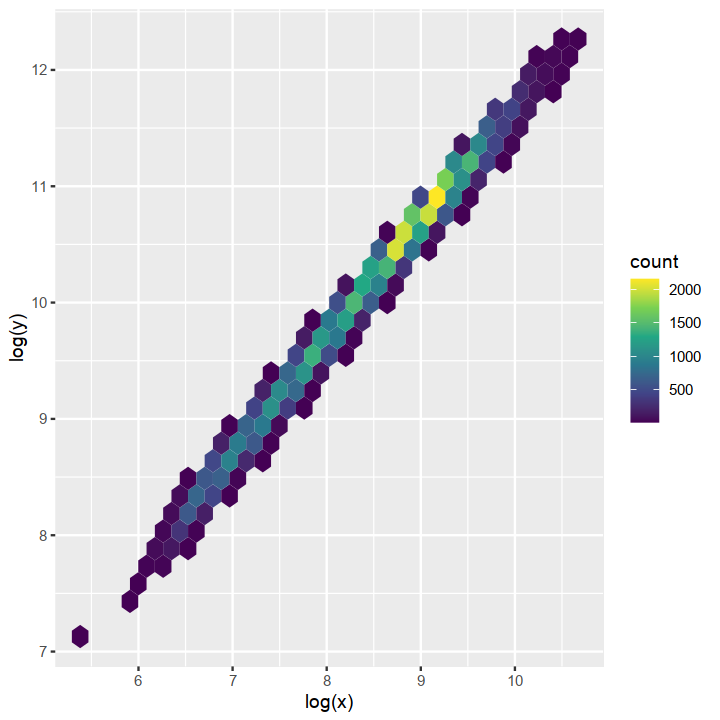

In [57]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data.frame(x=pmatRowSums, 
                  y=abs(raw_dot_prod[,1])),
      aes(x=log(x), y=log(y))) +
scale_fill_continuous(type = "viridis") +
geom_hex() 
# geom_point() +
# coord_cartesian(xlim=c(0,quantile(pmatRowSums,0.95)))

In [58]:
quantile(dot_prod[,1]/pmatRowSums, 0.95)

95% 
0.2498803

In [77]:
raw_sim_plots = list()

j = 1
for (i in sub("hr", "h", lapply(strsplit(colnames(data.use), "\\."), "[[", 2))) {
    name = strsplit(i, "\\.")
    sim_score = raw_dot_prod[,j]/pmatRowSums
    df = data.frame(metaData, sim=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]

    ylabel=F
    if (i=="3h") {
        ylabel = "Raw Similarity"
    }
    
    raw_sim_plots[[i]] = plot_sim_umap(df, title=i, ylabel = ylabel, legend = F)
    
    j = j + 1
}

### Subtracting Co-culture

In [60]:
# compute delta counts from CC for 3/16/48 hr
het_CC_delta = het_binnorm_cts[, c("het.3hr.nodox.overlap","het.16hr.nodox.overlap","het.48hr.nodox.overlap")]
het_CC_delta = het_CC_delta - het_binnorm_cts[, "het.CC.nodox.overlap"]
head(het_CC_delta)

,het.3hr.nodox.overlap,het.16hr.nodox.overlap,het.48hr.nodox.overlap
chr1_10268_10885,0.000000,0,1.884156
chr1_41988_42505,0.000000,0,0.000000
chr1_46058_46558,0.000000,0,0.000000
chr1_48200_48959,0.000000,0,0.000000
chr1_51306_52190,1.285848,0,1.315716
chr1_58644_59144,0.000000,0,0.000000


In [61]:
het_CC_delta_log = sign(het_CC_delta)*log2(1+abs(het_CC_delta))
head(het_CC_delta_log)

,het.3hr.nodox.overlap,het.16hr.nodox.overlap,het.48hr.nodox.overlap
chr1_10268_10885,0.000000,0,1.528149
chr1_41988_42505,0.000000,0,0.000000
chr1_46058_46558,0.000000,0,0.000000
chr1_48200_48959,0.000000,0,0.000000
chr1_51306_52190,1.192729,0,1.211458
chr1_58644_59144,0.000000,0,0.000000


In [62]:
data.use = het_CC_delta_log

In [63]:
wo_cc_dot_prod = pmat %*% data.use

In [65]:
dim(wo_cc_dot_prod)

[1] 53906     3

In [66]:
cor(pmatRowSums, abs(wo_cc_dot_prod[,1])/pmatRowSums, method='spearman')

[1] -0.2629217

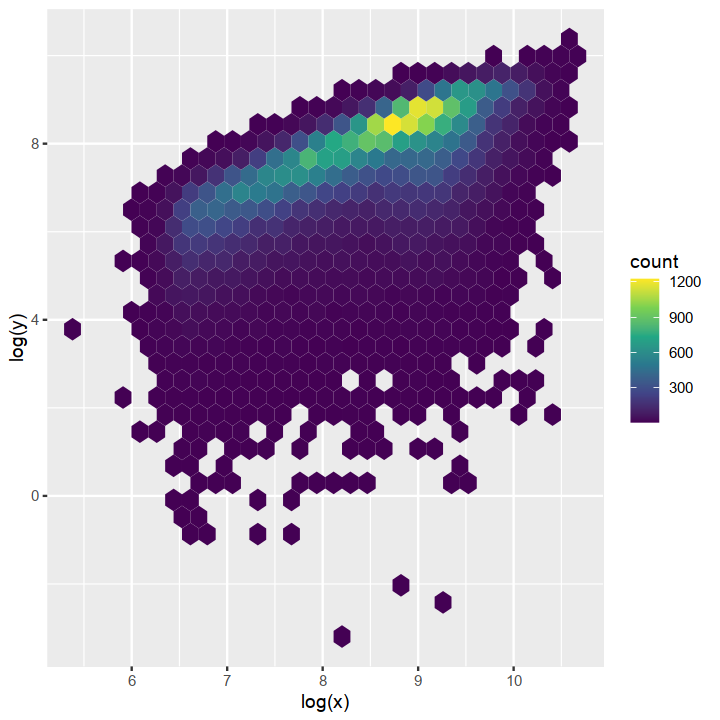

In [67]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data.frame(x=pmatRowSums, 
                  y=abs(wo_cc_dot_prod[,1])),
      aes(x=log(x), y=log(y))) +
scale_fill_continuous(type = "viridis") +
geom_hex() 
# geom_point() +
# coord_cartesian(xlim=c(0,quantile(pmatRowSums,0.95)))

In [81]:
wo_cc_sim_plots = list()

j = 1
for (i in sub("hr", "h", lapply(strsplit(colnames(data.use), "\\."), "[[", 2))) {
    name = strsplit(i, "\\.")
    sim_score = wo_cc_dot_prod[,j]/pmatRowSums
    df = data.frame(metaData, sim=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]

    ylabel=F
    if (i=="3h") {
        ylabel = "Without Co-culture Similarity"
    }
    
    leg=F
    if (i=="48h") {
        leg=T
    }
    
    wo_cc_sim_plots[[i]] = plot_sim_umap(df, title=F, ylabel = ylabel, legend = leg)
    
    j = j + 1
}

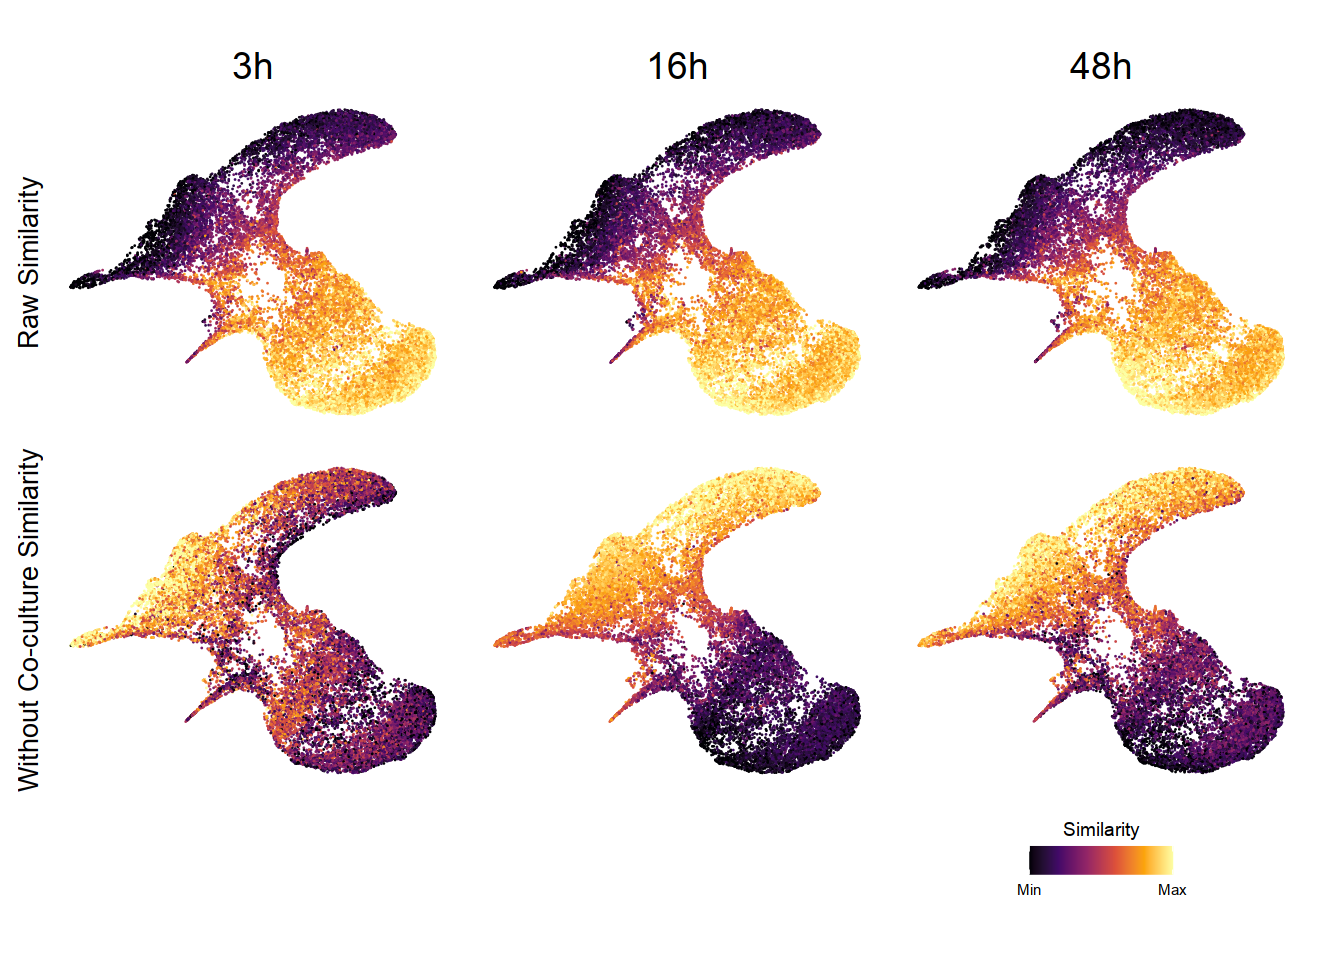

In [83]:
options(repr.plot.width = 11, repr.plot.height = 8)

combined_sims <- wrap_plots(c(raw_sim_plots[TO_PLOT],
           wo_cc_sim_plots[TO_PLOT]), 
           nrow=2)

combined_sims

In [84]:
saveRDS(combined_sims, file=sprintf("./subfigs/%s_atac_sim.rds",
                                format(Sys.Date(), "%Y%m%d")))

---

In [ ]:
sessionInfo()